In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

## 심부전 환자 로드

In [4]:
## 환자 ID, 심부전 발병일, 사망일, 생일이 있는 데이터
p_table = pd.read_csv("data/EHR_original_source/Participant_table.csv")
print(p_table.shape)
p_table.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/EHR_original_source/Participant_table.csv'

## 사망 여부, 사망 당시 나이, 현재 생존 나이, 생존기간 추출

In [3]:
## 사망 기록이 없으면 아직까지 생존한 것으로 판명
p_table['isSurvivor'] = p_table['Date of death | Instance 0'].isna()

## 생존자는 사망일이 기재 안 되어있으므로 오늘 날짜로 기입
p_table['Date of death | Instance 0'].fillna(datetime.date.today(), inplace=True)

## (사망일 - 심부전 발병일)을 기준으로 생존일자 계산
p_table['survived period'] = (pd.to_datetime(p_table['Date of death | Instance 0']) - pd.to_datetime(p_table['Date I50 first reported (heart failure)'])).dt.days
print(p_table.shape)

(19616, 6)


In [4]:
## 생존자 중 3650일 이하 생존자 제외 -> 언제 사망할지 모르고, Follow-up이 불확실하기 때문
p_table = p_table[(p_table['isSurvivor'] == False) | (p_table['survived period'] > 3650)]
print("filter : long survivor", p_table.shape)

## UK Biobank에 exomeseq이 있는 환자만 정리
with open("data/Exome_original_source/exome_list.txt", "r") as file:
    exome_list = file.readlines()
exome_list = [int(line.strip().split("/")[-1].split("_")[0]) for line in exome_list]
p_table = p_table[p_table['Participant ID'].isin(exome_list)]
print("filter : exome owning patients", p_table.shape)

## 데이터 프레임 정리
p_table = p_table.drop(columns = ["Year of birth", "isSurvivor", "Date I50 first reported (heart failure)", "Date of death | Instance 0"])
p_table = p_table.reset_index(drop = True)
p_table.head()

filter : long survivor (10425, 6)
filter : exome owning patients (9636, 6)


,Participant ID,survived period
0,1000058,2512
1,1001337,5351
2,1001473,53
3,1001801,3
4,1003080,4365


## 생존자 확인

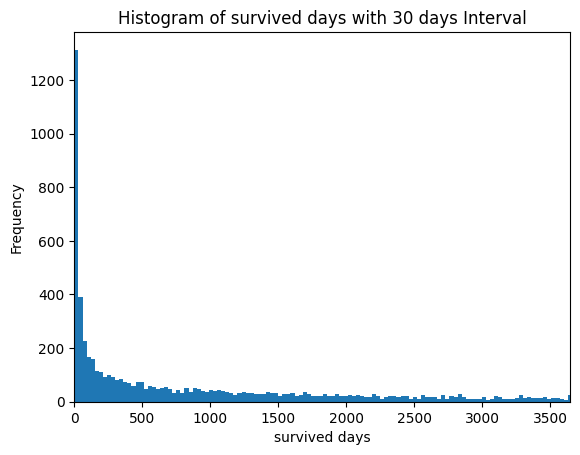

In [5]:
plt.hist(p_table["survived period"], bins=range(int(min(p_table["survived period"])), int(max(p_table["survived period"])) + 30, 30))
plt.xlabel("survived days")
plt.ylabel('Frequency')
plt.title(f'Histogram of survived days with 30 days Interval')
plt.xlim(0, 3650)
plt.show()

## 레이블링

In [6]:
# 90day, 800day
high_risk_condition = p_table['survived period'] < 90
low_risk_condition = p_table['survived period'] > 800
high_risk_indices = p_table.index[high_risk_condition]
low_risk_indices = p_table.index[low_risk_condition]

# 1: high risk
# 0: low risk
# -1: medium
p_table["risk"] = -1
p_table.loc[high_risk_indices, 'risk'] = 1
p_table.loc[low_risk_indices, 'risk'] = 0
p_table = p_table.reset_index(drop = True)

# 1: high risk
# 0: low risk
p_table["risk_one_year"] = p_table["survived period"] <= 365

# static
print()
print(p_table["risk"].value_counts())
print()
print(p_table["risk_one_year"].value_counts())
print()

p_table = p_table.drop(columns = ["survived period"])
p_table = p_table.reset_index(drop = True)
p_table.head()


risk
 0    5896
 1    1930
-1    1810
Name: count, dtype: int64

risk_one_year
False    6696
True     2940
Name: count, dtype: int64



,Participant ID,risk,risk_one_year
0,1000058,0,False
1,1001337,0,False
2,1001473,1,True
3,1001801,1,True
4,1003080,0,False


In [7]:
p_table.to_csv("data/Participant_table_labeled.csv", index = False)